In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym

# Common functions

In [2]:
# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))

In [3]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)

        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//nproc)):
            env.step(env.action_space.sample())
        return env
    return _f

# Globar variables

In [4]:
env_name = "LunarLanderContinuous-v2"
learning_rate = 0.0001

iterations = 10000
batch_size = 128*2
history_size = 128*2

nproc = 30
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy
        
# This code gets action and observation space sizes for 1D tasks
action_space_size = envs.action_space.n if isinstance(envs.action_space, gym.spaces.discrete.Discrete) else envs.action_space.shape[0]
observation_space_size = envs.observation_space.n if isinstance(envs.observation_space, gym.spaces.discrete.Discrete) else envs.observation_space.shape[0]

## Debug variables

In [5]:
plots_data = {
    "reward": [],
    "loss": [],
    "gradients_max_abs": [],
    "gradients_equal_zero": [],
    "max_action": [],
    "max_qvals": [],
    "min_qvals": [],
    "actions": [],
}

In [6]:
tf.reset_default_graph()
sess = tf.Session()

In [7]:
EPS = 1e-8
def gaussian_likelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [8]:
nn_input_state = tf.placeholder(tf.float32, shape=(None, observation_space_size), name="input_state")
nn_hidden_layer = tf.layers.dense(nn_input_state, units=64, activation="relu")
nn_output_layer = tf.layers.dense(nn_hidden_layer, units=action_space_size)

nn_action_ph = tf.placeholder(tf.float32, shape=(None, action_space_size), name="action_ph")
nn_reward_ph = tf.placeholder(tf.float32, shape=(None), name="reward_ph")

nn_log_std = tf.get_variable(name='log_std', initializer=-0.5*np.ones(action_space_size, dtype=np.float32))
nn_log_a = gaussian_likelihood(nn_action_ph, nn_output_layer, nn_log_std)

nn_std = tf.exp(nn_log_std)
action_op = nn_output_layer + tf.random_normal(tf.shape(nn_output_layer)) * nn_std
# nn_log_pi = gaussian_likelihood(nn_pi, nn_output_layer, nn_log_std)

nn_loss = -tf.reduce_mean(nn_reward_ph * nn_log_a)

nn_gradients = tf.gradients(nn_loss, tf.trainable_variables()) # For Debug!
nn_train_op = tf.train.AdamOptimizer(learning_rate).minimize(nn_loss)

W0719 23:24:16.651843 11524 deprecation.py:323] From <ipython-input-8-11b664470801>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0719 23:24:16.714840 11524 deprecation.py:506] From C:\Users\suriknik\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0719 23:24:17.604839 11524 deprecation.py:323] From C:\Users\suriknik\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.wh

In [9]:
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [10]:
def reward_to_go(rews):
    return np.cumsum(rews[::-1])[::-1]

# Batch generator

In [11]:
def batch_generator(batch_size, history_size):
    """
        history[0] = state
        history[1] = action
        history[2] = reward
    """
    history = np.empty((0, 3))
    trajectories = [np.empty((0, 3)) for _ in range(nproc)] # creating trajectory for each process
    observations = np.array([[0 for i in range(observation_space_size)] for j in range(nproc)]) #envs.reset()
    
    while True:
        history = history[batch_size:]
        while len(history) < history_size:
            observations_old = observations
            ############ action prediction ############
            actions = sess.run((action_op), feed_dict={
                    nn_input_state: observations_old,
                })
            ###########################################
            observations, rewards, dones, _ = envs.step(actions)
            
            for pid in range(nproc):
                trajectories[pid] = np.vstack((trajectories[pid], [observations_old[pid], actions[pid], rewards[pid]]))
                
                if dones[pid]:
                    plots_data["reward"].append(trajectories[pid][:, 2].sum())
                    trajectories[pid][:, 2] = reward_to_go(trajectories[pid][:, 2])
                    history = np.vstack((history, trajectories[pid]))
                    trajectories[pid] = np.empty((0, 3))
            
        np.random.shuffle(history)
        history = history[:history_size]
        yield history[:batch_size]

test_gen = batch_generator(400,400)

# Main cycle

In [45]:
batch_gen = batch_generator(batch_size, history_size)

for i in tqdm_notebook(range(iterations)):
    batch = next(batch_gen)
    
    _, loss, gradients = sess.run((nn_train_op, nn_loss, nn_gradients), feed_dict={
        nn_input_state: batch[:, 0].tolist(),
        nn_action_ph: batch[:, 1].tolist(),
        nn_reward_ph: batch[:, 2],
    })
    #****************** DEBUG ******************* 
    plots_data["loss"].append(loss)
    plots_data["gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients]))
    plots_data["gradients_equal_zero"].append(len(gradients[gradients == 0]))
    #*********************************************

KeyboardInterrupt: 

# Plotting

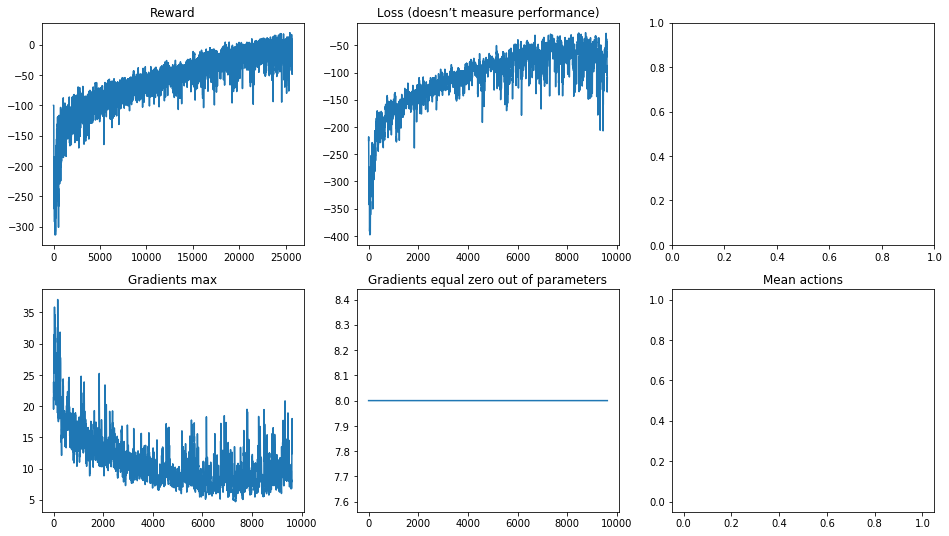

In [46]:
%matplotlib inline
#************ Plotting debug info ****************
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(plots_data["reward"], "Reward", axs[0, 0])
plot(plots_data["loss"], "Loss (doesn’t measure performance)", axs[0, 1])
plot(plots_data["gradients_max_abs"], "Gradients max", axs[1, 0])
plot(plots_data["gradients_equal_zero"], f"Gradients equal zero out of parameters", axs[1, 1])
plot(plots_data["actions"], "Mean actions", axs[1, 2])
plt.savefig('policy-plots.png')
#*************************************************

In [48]:
np.array(plots_data["reward"]).max()

86.875046

# Agent animation

In [47]:
env = gym.make(env_name)
observation = env.reset()
while True:
    try:
        action = sess.run((action_op), feed_dict={
            nn_input_state: [observation],
        })
        observation, reward, done, _ = env.step(action[0])
        env.render()
        
        if done:
            env.reset()
    except KeyboardInterrupt:
        env.close()
        break
env.close()

## Saving agent

In [ ]:
# import time
# # Save graph
# saver = tf.train.Saver()
# save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(plots_data["reward"][-50:]))}.ckpt')
# print("Model saved in path: %s" % save_path)

# saver = tf.train.Saver()
# saver.restore(sess, "./models/LunarLanderContinuous-v2-reward-96.ckpt")

In [44]:
envs.close()
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy